#AutoMeta RAG

Author: Darshil Modi [https://www.linkedin.com/in/darshil3011]

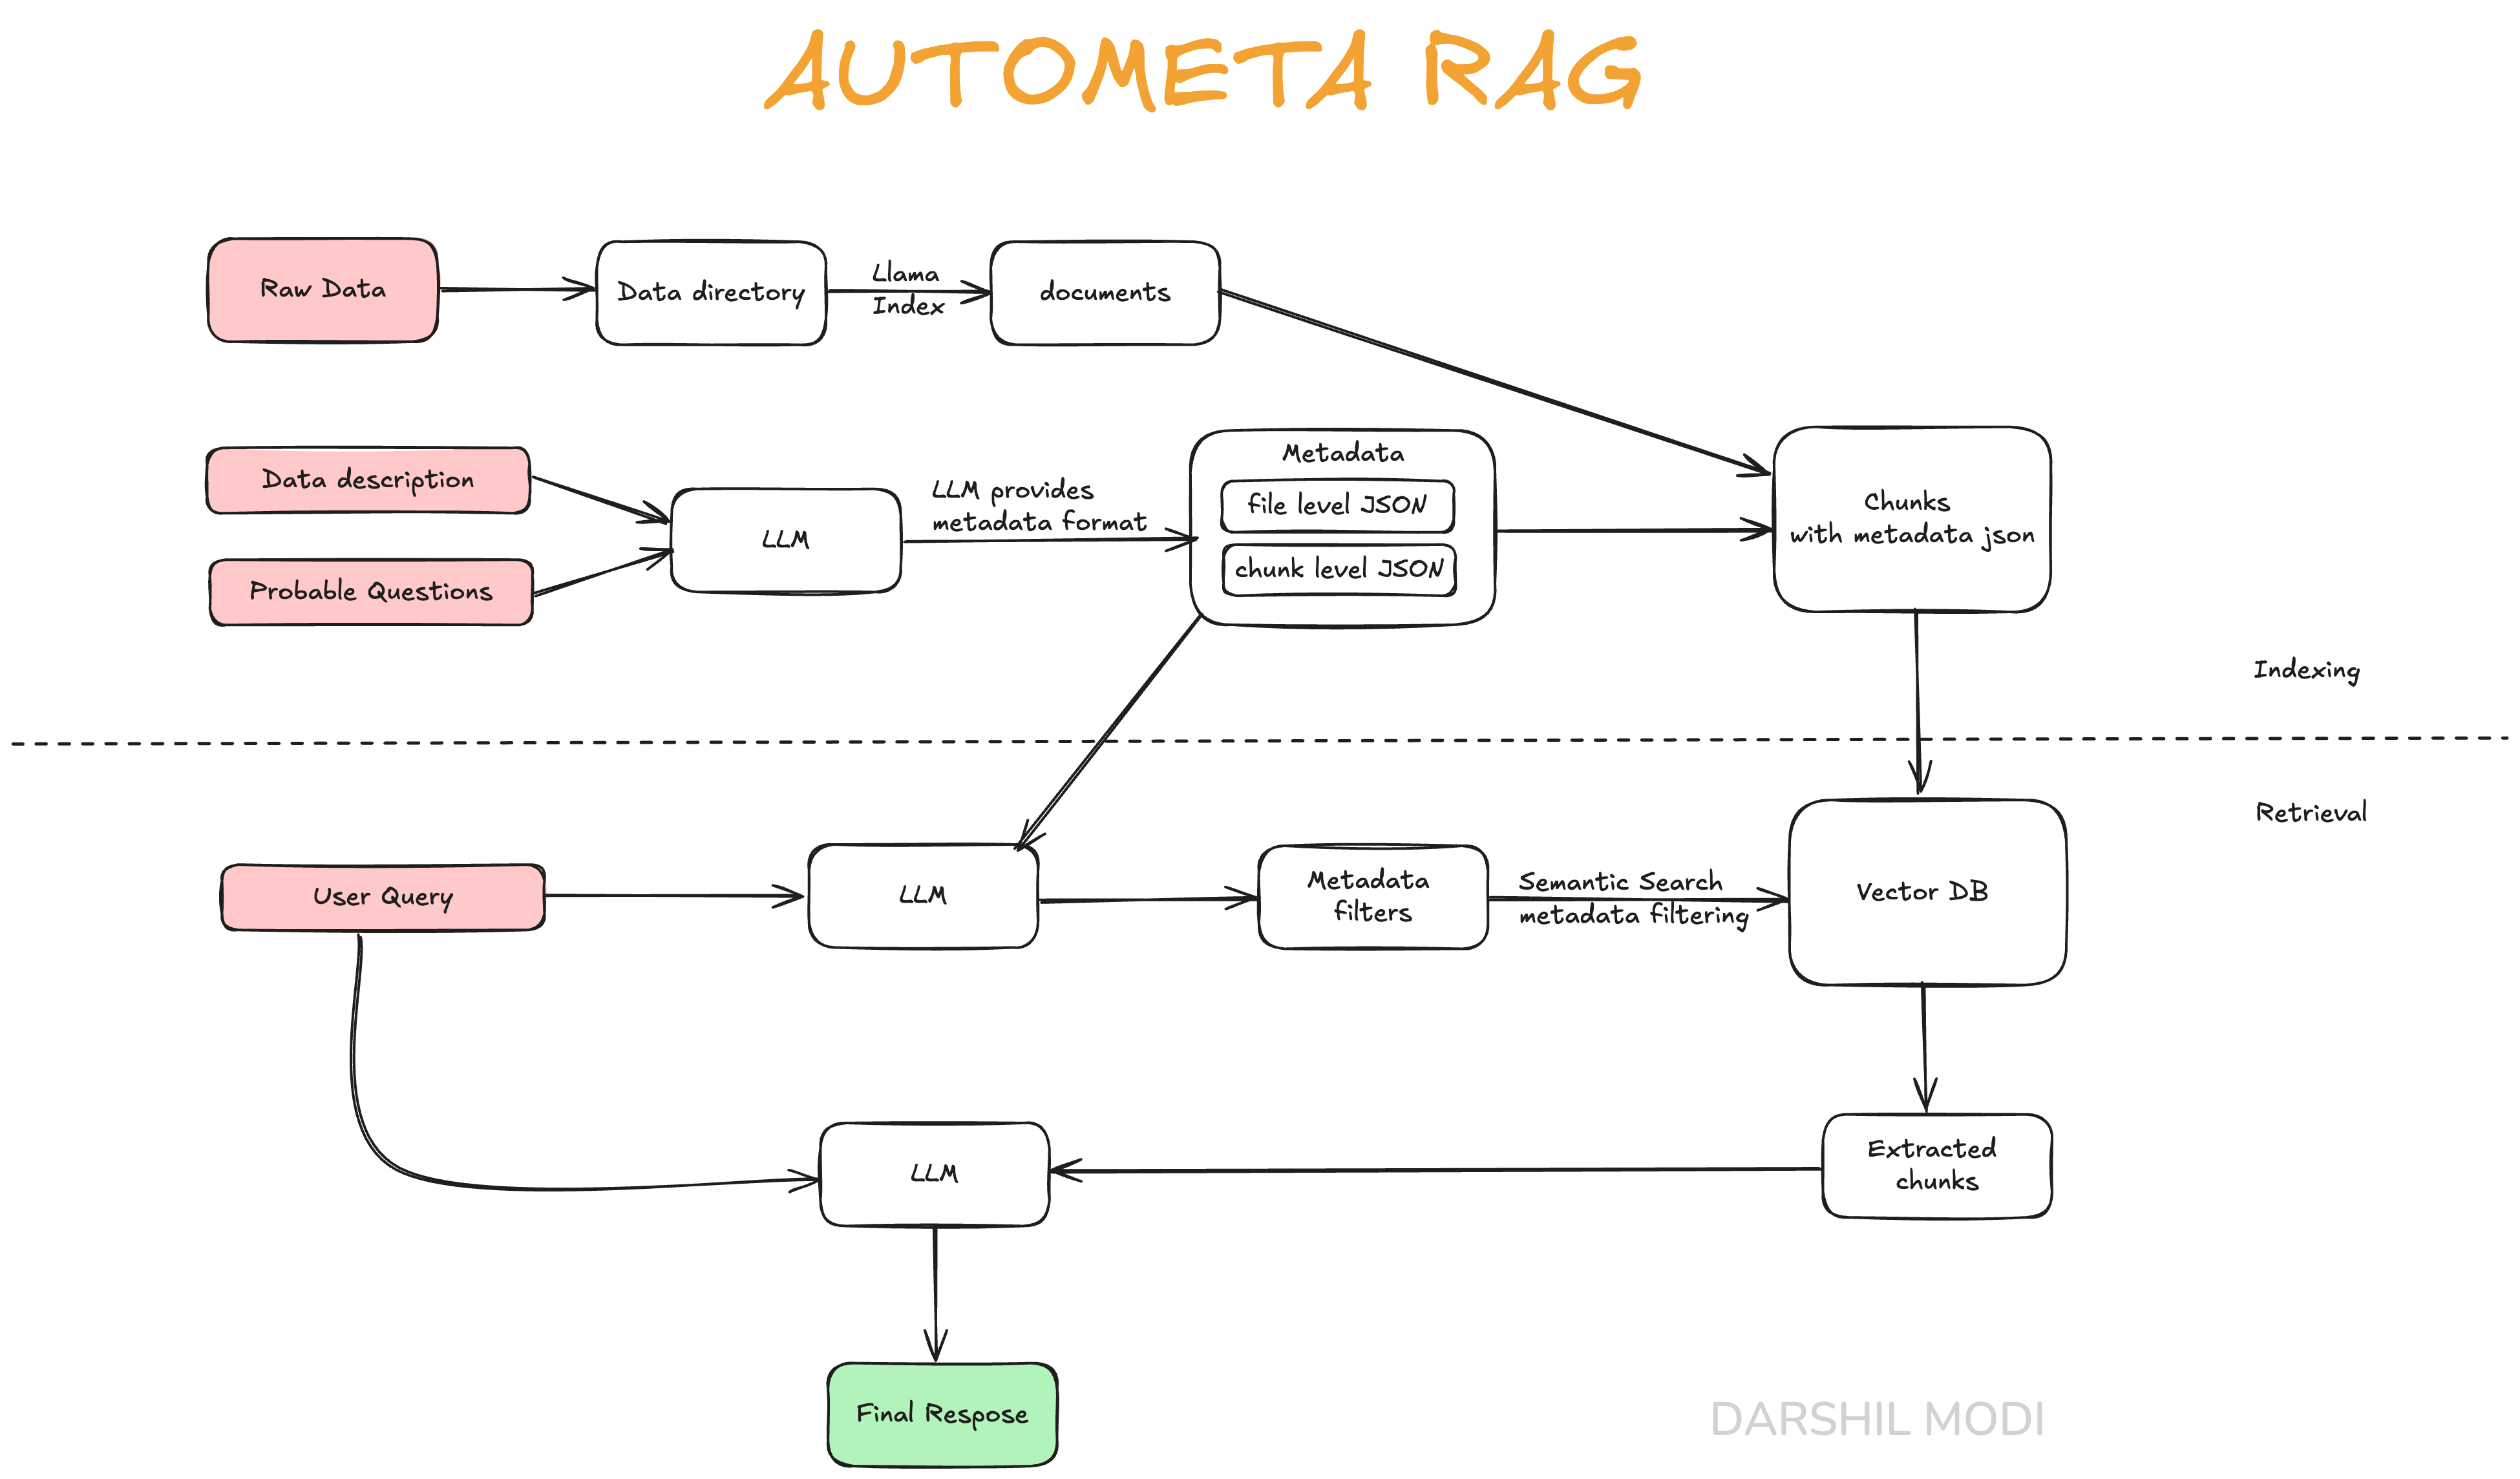

This notebook presents a Automatic Metadata based Retriever-Augmented Generator (AutoMeta RAG) framework designed to optimize the retrieval of data chunks from a large dataset by leveraging dynamic metadata schemas. The framework initiates by analyzing the dataset and anticipated user queries to suggest two types of metadata schemas: file-level and chunk-level. File-level metadata remains constant across all data chunks within a single file, providing a macro-view of the data attributes. Conversely, chunk-level metadata is unique for each data chunk, allowing for fine-grained indexing and retrieval.

Following the schema suggestion, the framework automates the extraction of metadata for each data chunk according to the defined schemas and stores these, along with the data vectors, into the VectorDB Qdrant. This storage method enhances the efficiency and accuracy of data retrieval processes.

On the inference side, the framework extracts metadata from incoming user queries based on the pre-determined schemas. It utilizes this metadata to perform targeted searches within the vector database, ensuring that the retrieved data chunks are the most relevant to the user's request. This method significantly improves the precision and speed of data retrieval, making it particularly useful for applications requiring rapid access to specific data segments within a large dataset

In [46]:
# !pip install openai
# !pip install llama-index
# !pip install qdrant_client
# !pip install transformers
# !pip install sentence-transformers

## MetaData Formatter - Ask LLM to define a metadata schema for the data

1. Add information about the data in config.ini
2. Add probable questions that you expect your end users might ask
3. LLM will analyse both the factors and provide two json
  - file level json : this will remain same for all chunks within same file
  - chunk level json : this will be unique for all chunks

In [10]:
import json
import openai
from configparser import ConfigParser
import re

def extract_json(text):
    # Regex pattern to find JSON objects
    json_pattern = r'\{[^{}]*\}'

    # Find all matches in the text
    matches = re.findall(json_pattern, text)

    # Convert matches to JSON
    json_objects = []
    for match in matches:
        try:
            json_object = json.loads(match)
            json_objects.append(json_object)
        except json.JSONDecodeError:
            continue  # Skip if it's not a valid JSON

    return json_objects

def metadata_formatter(config_path):
    # Read configuration file
    config = ConfigParser()
    config.read(config_path)

    # Extract information from the config file
    user_queries = config.get('Metadata', 'probable_questions')
    document_info = config.get('Metadata', 'document_info')

    # Prepare the prompt for OpenAI
    prompt = (''' I am indexing a large dataset for better retrieval. I want to break the data into chunks and index the chunks of data and store metadata of each chunk for better and accurate retrieval.

I will give you information about my dataset and list of probable questions that user may ask. It's not exact questions but just a set of examples. Analyse the data and type of probable questions and give me two lists of metadata that I should extract from each chunk of data for better retrieval.

One list will have metadata that can be extracted from first chunk such as file name, library name, date of file creation etc. Understand that this metadata will remain same for chunks within same file but will change when we index another file.

Another list will have metadata that are specific to that chunk of data like keywords, details or something specific depending upon dataset. But it should be metadata version of entire data chunk.

Your response should only contain two jsons of metadata to be extracted.


For example:

Dataset information: Documentation of python libraries like OpenCV and many others
LIst of probable questions: What is the use of cv2.imshow, How to install opencv-python, What are the keyword arguments for cv2.imread, how to use np.array ?

Analysis: since there are many libraries, one json will have library name, library version and last updated date. Since these data can be extracted
from first chunk of each file. Another json will be specific to the data inside each library documentation so it should have function name and function utility summary.

Your response: {"library_name":"", "library_version":"", "last_updated_date":""}, {"function_name": "", "function_utility_summary":""}

<example over>

Dataset information:''' + document_info +
'''Probable questions: ''' + user_queries )


    main_prompt = [
        {"role": "system", "content": "You are an expert LLM Engineer and Consultant."},
        {"role": "user", "content": prompt}
    ]

    # Use OpenAI API to generate a response
    client = openai.OpenAI(api_key='open_ai_key')

    response = client.chat.completions.create(
        model="gpt-4",
        messages=main_prompt,
        temperature=0
    )

    # Parse the response to JSON metadata format
    metadata_suggestion = response.choices[0].message.content
    print(metadata_suggestion)

    try:
        extracted_json = extract_json(metadata_suggestion)
        print(extracted_json)
    except json.JSONDecodeError:
        print("Failed to decode JSON. Here's the raw suggestion:")
        return metadata_suggestion

# Example usage
config_file_path = '/content/config.ini'
metadata = metadata_formatter(config_file_path)
print(metadata)


Your response: 

{"paper_title": "", "authors": "", "publication_date": ""}, {"section_name": "", "section_content_summary": ""}
[{'paper_title': '', 'authors': '', 'publication_date': ''}, {'section_name': '', 'section_content_summary': ''}]
None


## Chunk Data and add metadata as per the above schema

- Based on the above metadata schema, LLM will create metadata for all the chunks within your data
- It will identify unique files based on document_id
- File level metadata will remain same for all the chunks within the same file
- Chunk level metadata will be extracted for all the chunks

In [13]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Settings

documents = SimpleDirectoryReader("/content/data/", filename_as_id=True).load_data()

In [14]:
import openai
import json
import re

def process_documents(documents, json_formats, openai_api_key):
    """
    Process a list of documents, extracting JSON structures based on the file name similarity and merging them before sending to OpenAI.

    :param documents: List of LlamaIndex Document objects.
    :param json_formats: Tuple of two JSON format strings (json1, json2) that the user wants to extract.
    :param openai_api_key: OpenAI API key for making requests.
    :return: Dictionary of document IDs and their extracted and merged JSONs.
    """
    client = openai.OpenAI(api_key=openai_api_key)
    results = {}
    previous_file_name = None
    last_json1 = None

    for doc in documents:
        if doc.metadata['file_name'] == previous_file_name:
            # Same file name as the previous document, use the last JSON1 and request only JSON2
            json_to_extract = json_formats[1]
        else:
            # Different file name, request both JSONs
            json_to_extract = f"{json_formats[0]}\n\n{json_formats[1]}"

        # Prepare the OpenAI prompt
        prompt = f"Extract the following JSON structures from the text. Don't respond with anything extra. Just the json / jsons given: {json_to_extract}\n\nText:\n{doc.text}"
        main_prompt = [
            {"role": "system", "content": "You are an expert JSON extractor and data analyst."},
            {"role": "user", "content": prompt}
        ]

        response = client.chat.completions.create(
            model="gpt-3.5-turbo-16k",
            messages=main_prompt,
            temperature=0
        )

        # Extract JSON and attempt to merge
        try:
            # Extract JSON using regex from the response content
            json_pattern = r'\{.*?\}'
            extracted_json = re.findall(json_pattern, response.choices[0].message.content)[0]
            extracted_dict = json.loads(extracted_json)

            # Merge JSONs as required
            if doc.metadata['file_name'] == previous_file_name and last_json1 is not None:
                merged_json = {**json.loads(last_json1), **extracted_dict}
            else:
                last_json1 = json.dumps(extracted_dict)  # Update last_json1 with new JSON
                merged_json = extracted_dict  # This includes both JSON1 and JSON2

            print(merged_json)

            results[doc.id_] = json.dumps(merged_json)

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for document {doc.id_}: {e}")
        except KeyError as e:
            print(f"Key error: {e} in document {doc.id_}")
        except Exception as e:
            print(f"An error occurred: {e}")

        previous_file_name = doc.metadata['file_name']

    return results

# put the json as per the schema presented by LLM above
''' TO DO: Automatically extract JSON from above cell and pass it here using json.loads/dumps '''

json_formats = ('{"paper_title": "", "authors": "", "publication_date": ""}', '{"section_name": "", "section_content_summary": ""}')
api_key = 'open_ai_key'

extracted_jsons = process_documents(documents, json_formats, api_key)


{'paper_title': 'Attention Is All You Need', 'authors': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin', 'publication_date': '2 Aug 2023'}
{'paper_title': 'Attention Is All You Need', 'authors': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin', 'publication_date': '2 Aug 2023', 'section_name': 'Introduction', 'section_content_summary': 'This section discusses the advancements in recurrent neural networks and their applications in sequence modeling and transduction problems. It highlights the limitations of sequential computation and introduces the Transformer model, which relies entirely on attention mechanisms for improved parallelization and performance.'}
{'paper_title': 'Attention Is All You Need', 'authors': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin', 'pub

In [47]:
# save json for later use, so you dont have to recreate metadata incase code crashes
import json
with open('data.json', 'w') as f:
    json.dump(extracted_jsons, f)

## Create VectorDB and add chunks with Metadata
1. Create Qdrant DB
2. Map chunks with document_id and add metadata from extracted_jsons
3. Encode chunks text content and ingest to the DB along with metadata

In [18]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct
from sentence_transformers import SentenceTransformer

# Configuration for Qdrant
QDRANT_URL = 'qdrant_cloud_URL'
ACCESS_TOKEN = 'qdrant_access_token'

# Initialize the Qdrant client
client = QdrantClient(url=QDRANT_URL, api_key=ACCESS_TOKEN)
collection_name = 'AutoRAG'

# Initialize the sentence transformer model
encoder = SentenceTransformer("all-MiniLM-L6-v2")

# Prepare points to be uploaded
points = []
index = 0
for document in documents:
  if document.id_ in extracted_jsons:
      metadata = extracted_jsons[document.id_]

      # Encode the document text into a vector
      vector = encoder.encode(document.text)

      # Create a point with the metadata and the encoded vector
      point = PointStruct(
          id=index,
          payload=json.loads(metadata),
          vector=vector  # Convert numpy array to list
      )
      points.append(point)

  index += 1

# Batch upload points to the collection
client.upsert(collection_name=collection_name, points=points)

print(f"Successfully ingested {len(points)} documents into the Qdrant collection.")


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Successfully ingested 38 documents into the Qdrant collection.


## Inference

1. Load VectorDB
2. Extract metadata from user query based on JSON schema
3. Use Metadata filtering for extracting relevant chunks using RAG

In [48]:
# load json
import json

# Opening JSON file
f = open('data.json')

# returns JSON object as
# a dictionary
data = json.load(f)

## Create Master JSON
1. Identify unique values for each key in your extracted json metadata
2. This will help LLM to extract metadata from user query for filtering Qdrant DB
3. Pass master json and user query to LLM to extract metadata from it
4. Use the metadata filtering + user query to extract relevant chunks from Qdrant DB

In [22]:
def extract_unique_nested_values(json_data):
    unique_values = {}

    # Iterate through each document
    for document in json_data.values():
        # Convert the stringified JSON data into a dictionary
        nested_data = json.loads(document)

        # Process each key-value pair in the nested JSON
        for key, value in nested_data.items():
            if key not in unique_values:
                unique_values[key] = set()
            unique_values[key].add(value)

    # Convert sets back to lists for JSON serialization
    return {key: list(values) for key, values in unique_values.items()}

# Extract unique values per key in nested JSONs
unique_values_per_key = extract_unique_nested_values(data)
print(json.dumps(unique_values_per_key, indent=4))

{
    "paper_title": [
        "An Introduction to Convolutional Neural Networks",
        "MusicLM: Generating Music From Text",
        "Attention Is All You Need"
    ],
    "authors": [
        "Keiron O\u2019Shea, Ryan Nash",
        "Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, \u0141ukasz Kaiser, Illia Polosukhin",
        "Andrea Agostinelli, Timo I. Denk, Zal\u00e1n Borsos, Jesse Engel, Mauro Verzetti, Antoine Caillon, Qingqing Huang, Aren Jansen, Adam Roberts, Marco Tagliasacchi, Matt Sharif, Neil Zeghidour, Christian Frank"
    ],
    "publication_date": [
        "2 Dec 2015",
        "2 Aug 2023",
        "26 Jan 2023"
    ],
    "section_name": [
        "References",
        "Pooling layer",
        "MusicLM: Generating Music From Text",
        "Genre distribution of all 5.5k examples of MusicCaps",
        "A. MusicCaps Dataset",
        "Variations on the Transformer architecture",
        "Input-Input Layer5",
        "Atte

In [33]:
import openai
import json
import re

def filter_metadata_by_query(unique_values_json, user_query, openai_api_key):
    """
    Use OpenAI to extract relevant entries from a unique values JSON based on a user query.
    Uses a structured prompt for the OpenAI model.

    :param unique_values_json: A dictionary with keys and list of unique values
    :param user_query: User's query string to analyze
    :param openai_api_key: OpenAI API key for making requests
    :return: A filtered dictionary based on the query
    """
    # Initialize the OpenAI client
    client = openai.OpenAI(api_key=openai_api_key)

    # Construct the prompt
    prompt = ''' You will be given a query and master data JSON. The query is to be used for performing hybrid search on a vector database.
    Your job is to analyse the query and respond with key-value pairs that you can find out from the master data JSON. Dont focus on answering
    the query. Just find out which key-value pairs matches the master data.

    For example: Master json is {'price' : ['0$-100$', '100$-500$', '500$-1000$', '1000$+'], 'product_category': ['clothes, accessories', 'mobiles, laptops', 'grocery, essentials']}

    Query is "What are some good options for Mens black Tshirt"

    Your response should be {'product_category':'clothes, accessories'}


    Here is the master data json: ''' + json.dumps(unique_values_json) + '''User Query: ''' + user_query + '''Your response: '''


    main_prompt = [
        {"role": "system", "content": "You are an expert JSON extractor and data analyst."},
        {"role": "user", "content": prompt}
    ]

    # Make the request to OpenAI
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=main_prompt,
        temperature=0
    )

    # Parse and return the model's response
    print(response.choices[0].message.content)

    try:
        json_pattern = r'\{.*?\}'
        extracted_json = re.findall(json_pattern, response.choices[0].message.content, re.DOTALL)[0]
        relevant_entries = json.loads(extracted_json)
        return relevant_entries

    except json.JSONDecodeError:
        return {"error": "Failed to decode response from OpenAI"}


user_query = "I want to know about experimentations performed in research paper by Adam Roberts"
api_key = 'open_ai_key'

result = filter_metadata_by_query(unique_values_per_key, user_query, api_key)



```json
{
  "authors": "Andrea Agostinelli, Timo I. Denk, Zalán Borsos, Jesse Engel, Mauro Verzetti, Antoine Caillon, Qingqing Huang, Aren Jansen, Adam Roberts, Marco Tagliasacchi, Matt Sharif, Neil Zeghidour, Christian Frank"
}
```


## RAG : Pass Metadata Filter + User Query to Qdrant Search

In [35]:
from sentence_transformers import SentenceTransformer
from qdrant_client import QdrantClient
from qdrant_client.http import models

encoder = SentenceTransformer("all-MiniLM-L6-v2")

QDRANT_URL = 'qdrant_cloud_URL'
ACCESS_TOKEN = 'access_token'

# Initialize the Qdrant client
client = QdrantClient(url=QDRANT_URL, api_key=ACCESS_TOKEN)
collection_name = 'autoRAG'

from qdrant_client.http.models import PointStruct, Filter, FieldCondition, Range



metadata_filter = Filter(
    should=[
        FieldCondition(
            key=list(result.keys())[0],
            match={"value": list(result.values())[0]}
        )
    ]
)




In [44]:
hits = client.search(
    collection_name="AutoRAG",
    query_vector=encoder.encode("I want to know about experimentations performed in research paper by Adam Roberts").tolist(),
    limit=3,  query_filter = metadata_filter
)


for hit in hits:
    print(hit.id)
    print(hit.id, "score:", hit.score)
    print(hit.payload['paper_title'])
    print(hit.payload['section_content_summary'])
    print('-------------------------------------')


39
39 score: 0.10988235
MusicLM: Generating Music From Text
Participants in the listening test evaluated two 10-second clips against a text caption on a 5-point Likert scale, focusing on text-music matching rather than audio quality. A total of 1200 ratings were collected, with significant results from pairwise comparisons analyzed using the Wilcoxon signed-rank test.
-------------------------------------
34
34 score: 0.10415572
MusicLM: Generating Music From Text

-------------------------------------
40
40 score: 0.10258956
MusicLM: Generating Music From Text
The section discusses the performance of various music generation systems, highlighting MusicCaps as the best match for captions, followed closely by MusicLM. It also provides implementation details of a model for melody conditioning in music generation, describing its architecture, training process, and the use of melody embeddings.
-------------------------------------


## RAG - Passing retrieved data chunks to LLM for Final Response

To do:
- Instead of passing summary, need to reference original content and pass that to LLM for better response and no hallucinations

In [52]:
context = [hit.payload['section_content_summary'] for hit in hits]

In [53]:
user_query = "I want to know about experimentations performed in research paper by Adam Roberts "

In [57]:
# Construct the prompt
prompt = f'''Based on the provided context information from the dataset, generate a comprehensive answer for the user query.
Context: {context}
User Query: {user_query}'''


main_prompt = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]

client = openai.OpenAI(api_key='open_ai_key')

# Make the request to OpenAI
response = client.chat.completions.create(
    model="gpt-4o",
    messages=main_prompt,
    temperature=0
)

# Parse and return the model's response
print(response.choices[0].message.content)


In the research paper by Adam Roberts, the experimentations involved a listening test where participants evaluated two 10-second music clips against a text caption. The evaluation was based on a 5-point Likert scale, focusing specifically on how well the music matched the text caption rather than the audio quality. A total of 1200 ratings were collected from these evaluations.

The results of the experiment were analyzed using the Wilcoxon signed-rank test to determine the significance of pairwise comparisons. The findings highlighted that the MusicCaps system provided the best match for the captions, with MusicLM following closely behind.

Additionally, the paper discusses the implementation details of a model designed for melody conditioning in music generation. This includes a description of the model's architecture, the training process, and the use of melody embeddings to enhance the music generation process.
